In [1]:
#%matplotlib inline

# Import all the programs we want to use. If this gives an error, then you need to add these to your python path.

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
#import holopy as hp
import os
#import av
import scipy
import scipy.optimize as sco
import seaborn
from matplotlib.backends.backend_pdf import PdfPages

#%matplotlib notebook

from __future__ import division  # this makes mathematical division work better
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
scaling =  0.08431 #um/pixel
mpp = scaling
fps = 11.935
moviename = 'tracer+janus_3%_H2O2_5(green)2016-06-14'
os.chdir('C:\\Users\\Viva\\Desktop\\EPJ folder\\analysis')
tm = pd.read_pickle('filtered_data_with_drift_subtracted_tracer+janus_3%_H2O2_5(green)2016-06-14_pickled.pkl')
tracks = tm['particle'].astype(int).unique()

print size(tracks)
tm.head()

410


,x,y,relative_to_frame,x_raw,y_raw,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,,,,
1,334.271179,212.315119,0,332.555782,212.905931,2400.095318,4.244409,0.022435,26.408594,9782.0,0.113745,1,12.0
1,673.982923,253.024125,0,672.318464,253.187598,3871.088289,4.323736,0.037196,41.842188,11701.0,0.067698,1,16.0
1,461.220389,329.668033,0,459.652504,330.099069,5590.047668,4.382587,0.005051,56.246875,16907.0,0.032264,1,21.0
1,108.901070,344.408378,0,107.352006,345.282568,2439.536724,4.300599,0.051282,27.780469,8240.0,0.250852,1,24.0
1,67.245335,500.488073,0,65.892629,501.414536,2054.725786,4.132527,0.037877,26.408594,8049.0,0.294879,1,43.0


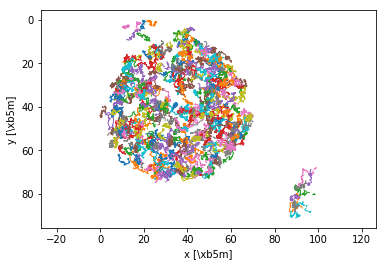

In [3]:
plt.axis('equal')
ax = tp.plot_traj(tm, mpp = scaling, legend=False)

In [4]:
imsd = tp.imsd(tm, scaling, fps, max_lagtime=1000)

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\nMSD')

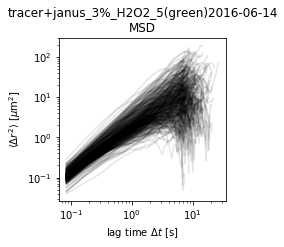

In [5]:
fig, ax = plt.subplots()
ax.plot(imsd.index, imsd, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(moviename + '\nMSD')

In [6]:
emsd = tp.emsd(tm, scaling, fps,max_lagtime=60)

Text(0.5,0,u'$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]')

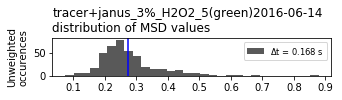

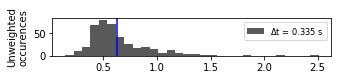

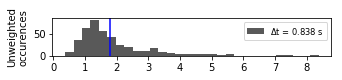

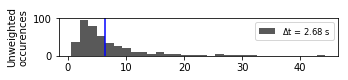

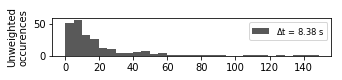

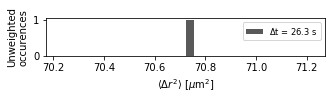

In [7]:
# I wonder whether these datapoints are normally distributed.

first = True
for i in np.logspace(0,log(len(imsd)-1)/log(10),num=6, dtype=int, base=10):
    #print i
    fig = figure(figsize=[5,.7])
       
    # plot a histogram of the MSD values for a single lag time
    imsd.iloc[i].hist(bins=30, grid = False, histtype='stepfilled', color='.35'
                               ,label=r'$\Delta$t = {:.3} s'.format(imsd.index[i]))
    
    try:
        # plot a vertical line showing the ensemble mean square displacement for a single lag time
        axvline(x=emsd.iloc[i], color='b', linewidth=1.5)
           #,label='mean {:.2}'.format(emsd_zero_perox.iloc[i]))
    except IndexError:
        pass
    
    if first:
        plt.title(moviename + '\ndistribution of MSD values', loc='left') 
        first = False
    plt.ylabel('Unweighted\noccurences')
    plt.legend(frameon=True, fontsize='small', markerscale= 1)

plt.xlabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')

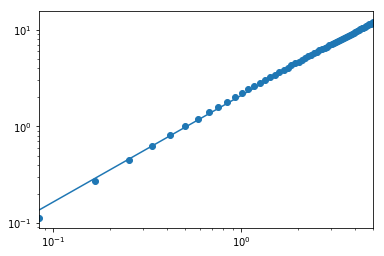

,n,A
msd,1.104948,2.102806


In [8]:
res = tp.utils.fit_powerlaw(emsd)  # performs linear best fit in log space, plots
res

In [9]:
t0 = frange(.0666,10,.1)
fit = res.A[0]*(t0**res.n[0])

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\n2D MSD')

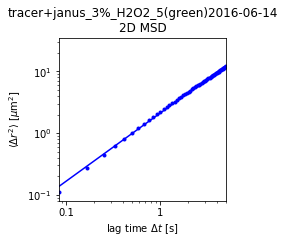

In [10]:
ax =emsd.plot(loglog=True, style='b.',linewidth=.3, grid=False, figsize = [3,3], label="emsd")

# plot fit
loglog(t0,fit, 'b')

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
#ax.set_xticks([.1,1,10])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.title(moviename + "\n2D MSD")

#savefig('/home/viva/group/viva/Analysis/2016-03-02/MSD_of_tracers_in_droplets_containing_both_tracers_and_Janus_particles.pdf')
#savefig('/home/viva/group/viva/Analysis/2016-03-02/MSD_of_tracers_in_droplets_containing_both_tracers_and_Janus_particles.png')

In [11]:
# A new version of tp.motion.emsd() that calculates standard deviation.
# This function is copied from trackpy. (Please see the trackpy license.)
# I [Viva] added the calculation of biased weighted standard deviation.

def my_emsd(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=None):
    """Compute the ensemble mean squared displacements of many particles.

    Parameters
    ----------
    traj : DataFrame of trajectories of multiple particles, including
        columns particle, frame, x, and y
    mpp : microns per pixel
    fps : frames per second
    max_lagtime : intervals of frames out to which MSD is computed
        Default: 100
    detail : Set to True to include <x>, <y>, <x^2>, <y^2>. Returns
        only <r^2> by default.

    Returns
    -------
    Series[msd, index=t] or, if detail=True,
    DataFrame([<x>, <y>, <x^2>, <y^2>, msd, N, lagt,
               std_<x>, std_<y>, std_<x^2>, std_<y^2>, 
               std_msd],
              index=frame)

    Notes
    -----
    Input units are pixels and frames. Output units are microns and seconds.
    """
    ids = []
    msds = []
    for pid, ptraj in traj.reset_index(drop=True).groupby('particle'):
        msds.append(tp.motion.msd(ptraj, mpp, fps, max_lagtime, True, pos_columns))
        ids.append(pid)
    msds = pd.concat(msds, keys=ids, names=['particle', 'frame'])
    results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
    results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
    # Above, lagt is lumped in with the rest for simplicity and speed.
    # Here, rebuild it from the frame index.
    
    if not detail:
        return results.set_index('lagt')['msd']

    # Calculation of biased weighted standard deviation
    numerator = ((msds.subtract(results))**2).mul(msds['N'], axis=0).sum(level=1)
    denominator = msds['N'].sum(level=1) # without Bessel's correction
    variance = numerator.div(denominator, axis=0)
    variance = variance[['<x>', '<y>', '<x^2>','<y^2>','msd']]
    std = np.sqrt(variance)
    std.columns = 'std_' + std.columns  

    return results.join(std)

detailed_emsd = my_emsd(tm, scaling, fps, detail=True, max_lagtime=100)

<Container object of 3 artists>

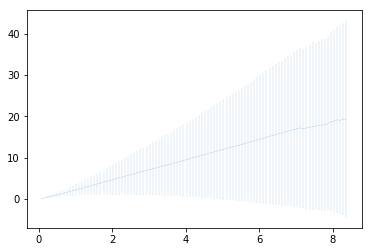

In [12]:
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")

values below 0 will not be plotted on loglog plot

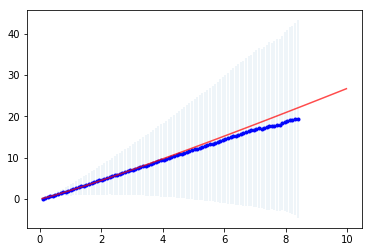

In [13]:
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")
plot(detailed_emsd.lagt, detailed_emsd.msd, 'b.',  label="ensemble msd")
plot(t0,fit, 'r', alpha=.7, label="power law fit") # plot fit

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


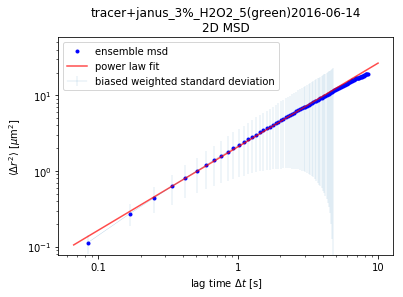

In [14]:
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")
loglog(detailed_emsd.lagt, detailed_emsd.msd, 'b.',  label="ensemble msd")
loglog(t0,fit, 'r', alpha=.7, label="power law fit") # plot fit

ax2 = plt.subplot(111)
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.title(moviename + "\n2D MSD")
plt.legend(loc=2, fontsize='medium')

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\n2D MSD, comparing imsd and emsd')

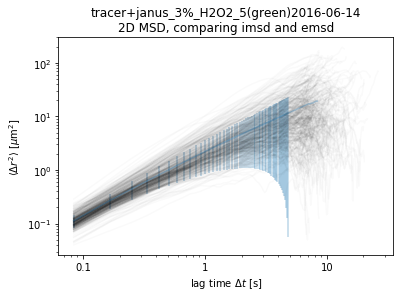

In [15]:
fig, ax = plt.subplots()

ax.plot(imsd.index, imsd, 'k-', alpha=0.02, label="MSD of each particle")
#loglog(t0,fit, 'r', alpha=.7, label="power law fit") # plot fit
plt.errorbar(detailed_emsd.lagt, detailed_emsd.msd, yerr = detailed_emsd.std_msd, capthick=0, 
             linewidth=1.5, alpha=.3,
             label="ensemble MSD with standard deviation")

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
plt.title(moviename + '\n2D MSD, comparing imsd and emsd')

Text(0.5,0,u'$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]')

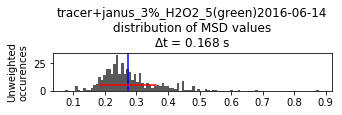

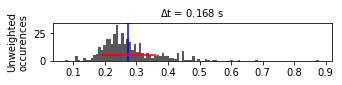

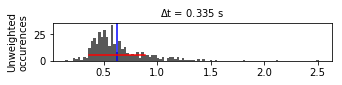

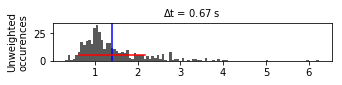

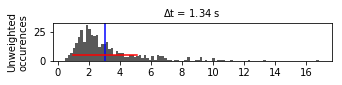

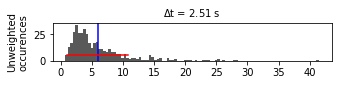

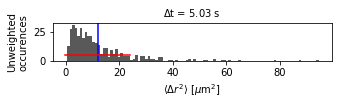

In [15]:
# I wonder whether these datapoints are normally distributed.

first = True
for i in np.logspace(0,log(len(emsd)-1)/log(10),num=7, dtype=int, base=10):
    #print i
    fig = figure(figsize=[5,.7])
       
    # plot a histogram of the MSD values for a single lag time
    imsd.iloc[i].hist(bins=100, grid = False, histtype='stepfilled', color='.35',
                      label=r'$\Delta$t = {:.3} s'.format(imsd.index[i]))
    
    # plot a blue vertical line showing the ensemble mean square displacement for a single lag time
    axvline(x=detailed_emsd.iloc[i].msd, color='b', linewidth=1.5)
           #,label='mean {:.2}'.format(emsd_zero_perox.iloc[i]))
        
    # plot a red horizontal line showing the standard deviation
    xmin = (detailed_emsd.iloc[i].msd)-(detailed_emsd.iloc[i].std_msd)
    xmax = (detailed_emsd.iloc[i].msd)+(detailed_emsd.iloc[i].std_msd)
    plot([xmin,xmax],[5,5], 'r')
    
    if first:
        plt.title(moviename + '\ndistribution of MSD values\n'+ '$\Delta$t = {:.3} s'.format(imsd.index[i])) 
        first = False
    else:
        plt.title('$\Delta$t = {:.3} s'.format(imsd.index[i]), fontdict={'fontsize':'medium'}, loc='center')
    plt.ylabel('Unweighted\noccurences')
    #plt.legend(frameon=True, fontsize='small')

plt.xlabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')

In [16]:
from scipy.optimize import curve_fit 

In [17]:
import scipy
scipy.__version__
# need at least version 14.0 of scipy.

'0.17.1'

In [18]:
def powerlaw(t, A, n):
    return (A * (t**n))

In [19]:
params, pcov = curve_fit(powerlaw, detailed_emsd.lagt, detailed_emsd.msd, 
                         #p0=[res.A[0], res.n[0]], 
                         sigma=detailed_emsd.std_msd,
                         absolute_sigma=True)

In [20]:
yfit = powerlaw(detailed_emsd.lagt,params[0],params[1])

#for y in yfit:
#    if y < 0:
#        yfit.replace(y, nan, inplace=True)

Text(0.02,20,u'Fit to power law, MSD = A * $\\Delta$t$^n$.\nExponent n = 1.12 $\\pm$ 0.054.\nCoefficient A = 2.03 $\\pm$ 0.162.')

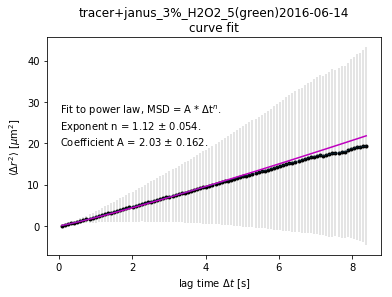

In [21]:
plot(detailed_emsd.lagt,detailed_emsd.msd, 'k.')
plot(detailed_emsd.lagt,yfit, 'm-')
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

plt.text(0.02,20, 
        'Fit to power law, MSD = A * $\Delta$t$^n$.'
         + '\nExponent n = {:.3} $\pm$ {:.3f}.'.format(params[1],sqrt(pcov[1,1]))
         + '\nCoefficient A = {:.3} $\pm$ {:.3f}.'.format(params[0],sqrt(pcov[0,0])))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

Text(0.1,10,u'Fit to power law, MSD = A * $\\Delta$t$^n$.\nExponent n = 1.12 $\\pm$ 0.054.\nCoefficient A = 2.03 $\\pm$ 0.162.')

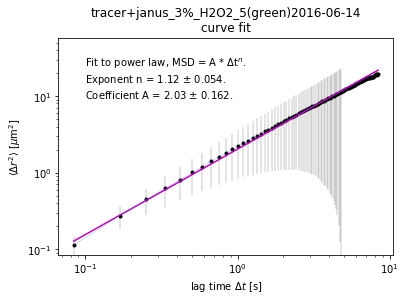

In [23]:
loglog(detailed_emsd.lagt,detailed_emsd.msd, 'k.')
loglog(detailed_emsd.lagt,yfit, 'm-')
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

plt.text(0.1,10, 
        'Fit to power law, MSD = A * $\Delta$t$^n$.'
         + '\nExponent n = {:.3} $\pm$ {:.3f}.'.format(params[1],sqrt(pcov[1,1]))
         + '\nCoefficient A = {:.3} $\pm$ {:.3f}.'.format(params[0],sqrt(pcov[0,0])))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [24]:
detailed_emsd.lagt.max()

8.378718056137398

In [24]:
pcov

array([[ 0.02632959, -0.00177814],
       [-0.00177814,  0.0028867 ]])

Text(0.5,1,u'Covariance matrix, absolute values')

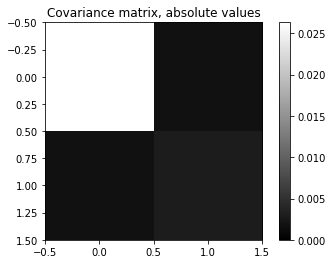

In [25]:
imshow(abs(pcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')

In [26]:
print moviename
print  'Coefficient A = ' + str(params[0]) + ' ± ' + str(np.sqrt(pcov[0,0]))
print 'Exponent n = ' + str(params[1]) + ' ± ' + str(np.sqrt(pcov[1,1]))

tracer+janus_3%_H2O2_5(green)2016-06-14
Coefficient A = 2.02746348935 ± 0.162263946613
Exponent n = 1.11760505485 ± 0.0537280062231


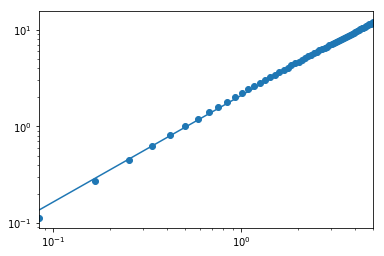

,n,A
msd,1.104948,2.102806


In [27]:


tp.utils.fit_powerlaw(emsd)

In [60]:
# Try linear fit

def linear(Dt,t):
    return 4*Dt*t

Dt, Dt_pcov = curve_fit(linear, detailed_emsd.lagt, detailed_emsd.msd)
print Dt
print Dt_pcov

[ 0.59232815]
[[  8.75533752e-07]]


In [61]:
Dt, Dt_pcov = curve_fit(linear, detailed_emsd.lagt, detailed_emsd.msd,
                        sigma=detailed_emsd.std_msd,
                        absolute_sigma=True)

print Dt
print Dt_pcov

Dt = Dt[0]
Dt_pcov=Dt_pcov[0][0]

print 'Dt = ' + str(Dt) +' ± '+ str(Dt_pcov)

linearfit=4*Dt*t0

[ 0.50074447]
[[ 0.00159179]]
Dt = 0.500744468972 ± 0.00159179206531


Text(0.02,35,u'Fit to line MSD $= 4D_t \\Delta t$ \n $D_t = $0.500744468972 $\\pm$ 0.00159179206531')

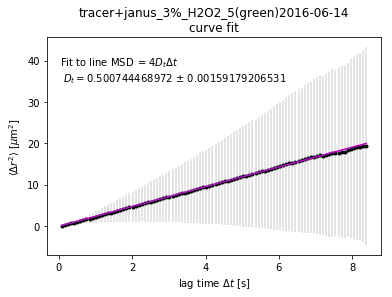

In [59]:
plot(detailed_emsd.lagt,detailed_emsd.msd, 'k.')
plot(detailed_emsd.lagt,linearfit, 'm-')
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

plt.text(0.02,35, 
        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [ ]:
## What about Zheng-style analysis?

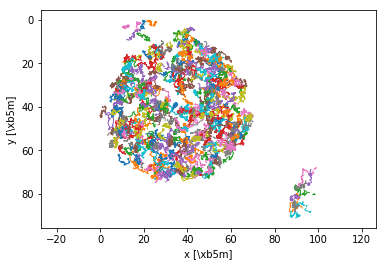

In [66]:
plt.axis('equal')
ax = tp.plot_traj(tm, mpp = scaling, legend=False)

In [87]:
long_detailed_emsd = my_emsd(tm, scaling, fps, detail=True, max_lagtime=400)

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

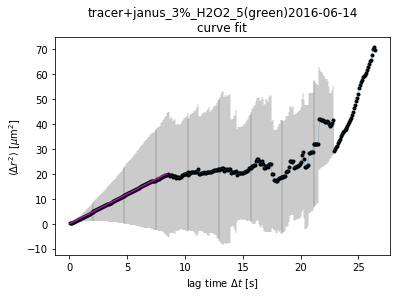

In [88]:
plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
plot(detailed_emsd.lagt,linearfit, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

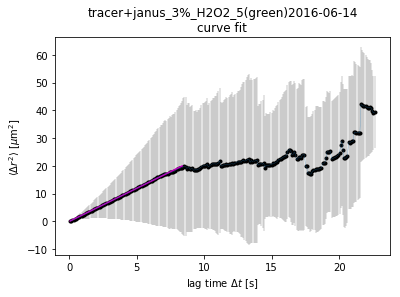

In [91]:
long_detailed_emsd = my_emsd(tm, scaling, fps, detail=True, max_lagtime=270)

plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
plot(detailed_emsd.lagt,linearfit, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

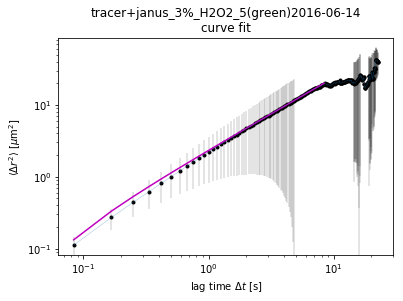

In [92]:
plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
loglog(detailed_emsd.lagt,linearfit, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [111]:
#Fit to Zheng's equation 6.
#For 1 um diameter particles, the MSD in um^2 is the same as the dimensionless MSD


def zheng(Dr, a, t):
    return (4/3)*Dr * t + (1/27)*(a**2) *(2*Dr*t - 1 * np.exp(-2*Dr*t))

zhengparams, zheng_pcov = curve_fit(zheng, long_detailed_emsd.lagt, long_detailed_emsd.msd,
                        sigma=long_detailed_emsd.std_msd,
                        absolute_sigma=True)
print zhengparams
print zheng_pcov



[ 0.86555665  1.19852121]
[[ 0.35314803 -0.02725048]
 [-0.02725048  0.00597679]]


Text(0.5,1,u'Covariance matrix, absolute values')

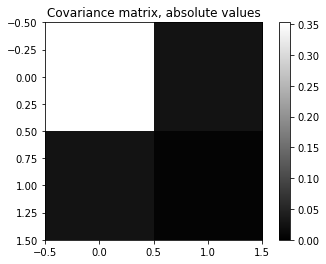

In [112]:
imshow(abs(zheng_pcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')

In [113]:
Drfit = zhengparams[0]
tau3 = Drfit * long_detailed_emsd.lagt
a3 = zhengparams[1]

print Drfit
print a3

fitzheng = (4/3)*tau3 + (1/27)*(a3**2) *(2*tau3 - 1 * np.exp(-2*tau3))

0.865556648353
1.19852121138


Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

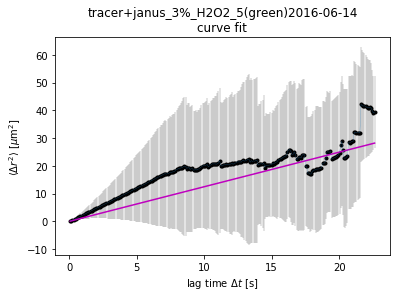

In [132]:
plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
plot(long_detailed_emsd.lagt,fitzheng, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [116]:
Drfixed = 1.1943936 #s^-1

def zheng2( a, t):
    return (4/3)*Drfixed * t + (1/27)*(a**2) *(2*Drfixed*t - 1 * np.exp(-2*Drfixed*t))

zhengparams2, zheng2_pcov = curve_fit(zheng2, long_detailed_emsd.lagt, long_detailed_emsd.msd)
print zhengparams2
print zheng2_pcov

tau4 = Drfixed * long_detailed_emsd.lagt
a4 = zhengparams[0]

print a4

fitzheng2 = (4/3)*tau4 + (1/27)*(a4**2) *(2*tau4 - 1 * np.exp(-2*tau4))

[ 0.92184023]
[[ 0.00036936]]
0.865556648353


Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

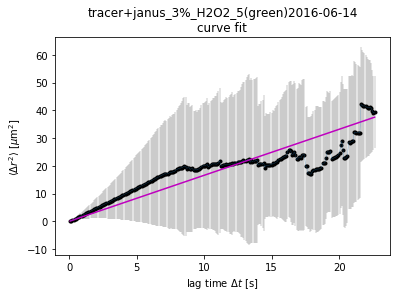

In [130]:
plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
plot(long_detailed_emsd.lagt,fitzheng2, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [128]:
Drfixed = 1.1943936 #s^-1
afixed = 2


fixzheng = (4/3)*tau4 + (1/27)*(afixed**2) *(2*tau4 - 1 * np.exp(-2*tau4))

Text(0.5,1,u'tracer+janus_3%_H2O2_5(green)2016-06-14\ncurve fit')

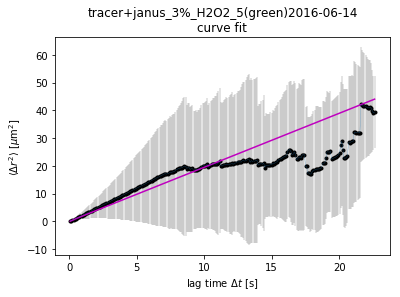

In [131]:
plot(long_detailed_emsd.lagt,long_detailed_emsd.msd, 'k.')
plot(long_detailed_emsd.lagt,fixzheng, 'm-')
plt.errorbar(long_detailed_emsd.lagt, 
             long_detailed_emsd.msd, 
             yerr = long_detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

#plt.text(0.02,35, 
#        'Fit to line MSD $= 4D_t \Delta t$ \n $D_t = $' +str(Dt) + ' $\pm$ ' + str(Dt_pcov))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance